# Зависимость рождаемости от брачности на основе анализа временных рядов

## 1) Визуальный анализ временного ряда брачности


### 1.1 Подготовка данных по брачности

##### Импорт необходимых для дальнейшей работы библиотек

In [1]:
import pandas as pd # библиотека для работы с табличными данными
import matplotlib.pyplot as plt # библиотека для построения графиков
import matplotlib.ticker as ticker # модуль управления тиками
from statsmodels.graphics.tsaplots import plot_acf # АКФ
import statsmodels.api as sm # библиотека статистических функций 
import datetime as dt # библиотека для работы с datetime

##### Загрузка данных из csv-файла в датафрейм pandas

In [79]:
df_marriage = pd.read_csv('divorce_marriage.csv', encoding='ansi')

##### Отображение структуры полученного датафрейма

In [80]:
df_marriage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28878 entries, 0 to 28877
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   territory               28878 non-null  int64  
 1   id_indicator            28878 non-null  int64  
 2   period                  28878 non-null  object 
 3   territory.ccube.0       28878 non-null  object 
 4   territory.ccube.1       28568 non-null  object 
 5   territory.ccube.2       26112 non-null  object 
 6   territory.ccube.attr.0  28878 non-null  int64  
 7   territory.ccube.3       28878 non-null  object 
 8   territory.ccube.4       28878 non-null  object 
 9   value                   28878 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


    - id_indicator - это id показателя (браки = 814, разводы = 816)
    - territory.ccube.(0-2) - это идентификатор уровня субъекта (0 - страна, 1 - федеральный округ, 2 - область или округ)
##### Выбор необходимого параметра и региона

In [81]:
df_m_clean = df_marriage.loc[(df_marriage['territory.ccube.3'] == 'Орловская область') & (df_marriage['id_indicator'] == 814)].reset_index(drop=True)

##### Удаление лишних колонок

In [82]:
df_m_clean = df_m_clean.drop(["territory", "id_indicator", "territory.ccube.0", "territory.ccube.1", "territory.ccube.2", "territory.ccube.attr.0", "territory.ccube.3", "territory.ccube.4"], axis=1)

In [83]:
df_m_clean.rename(columns={'period': 'дата', 'value': 'значение'}, inplace=True)

In [84]:
df_m_clean.head()

,дата,значение
0,31 Jan 2009 00:00:00,5.16
1,28 Feb 2009 00:00:00,6.84
2,31 Mar 2009 00:00:00,5.61
3,30 Apr 2009 00:00:00,6.20
4,31 May 2009 00:00:00,5.58


##### Преобразование формата даты

In [8]:
format = '%d %b %Y %H:%M:%S'

In [9]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strptime(str(x['дата']), format), axis=1)

In [10]:
new_format = '%d.%m.%Y'

In [11]:
df_m_clean['дата'] = df_m_clean.apply(lambda x: dt.datetime.strftime(x['дата'], new_format), axis=1)

In [12]:
df_m_clean.head()

,дата,значение
0,31.01.2009,5.16
1,28.02.2009,6.84
2,31.03.2009,5.61
3,30.04.2009,6.20
4,31.05.2009,5.58


### 1.2. Построение графика по брачности

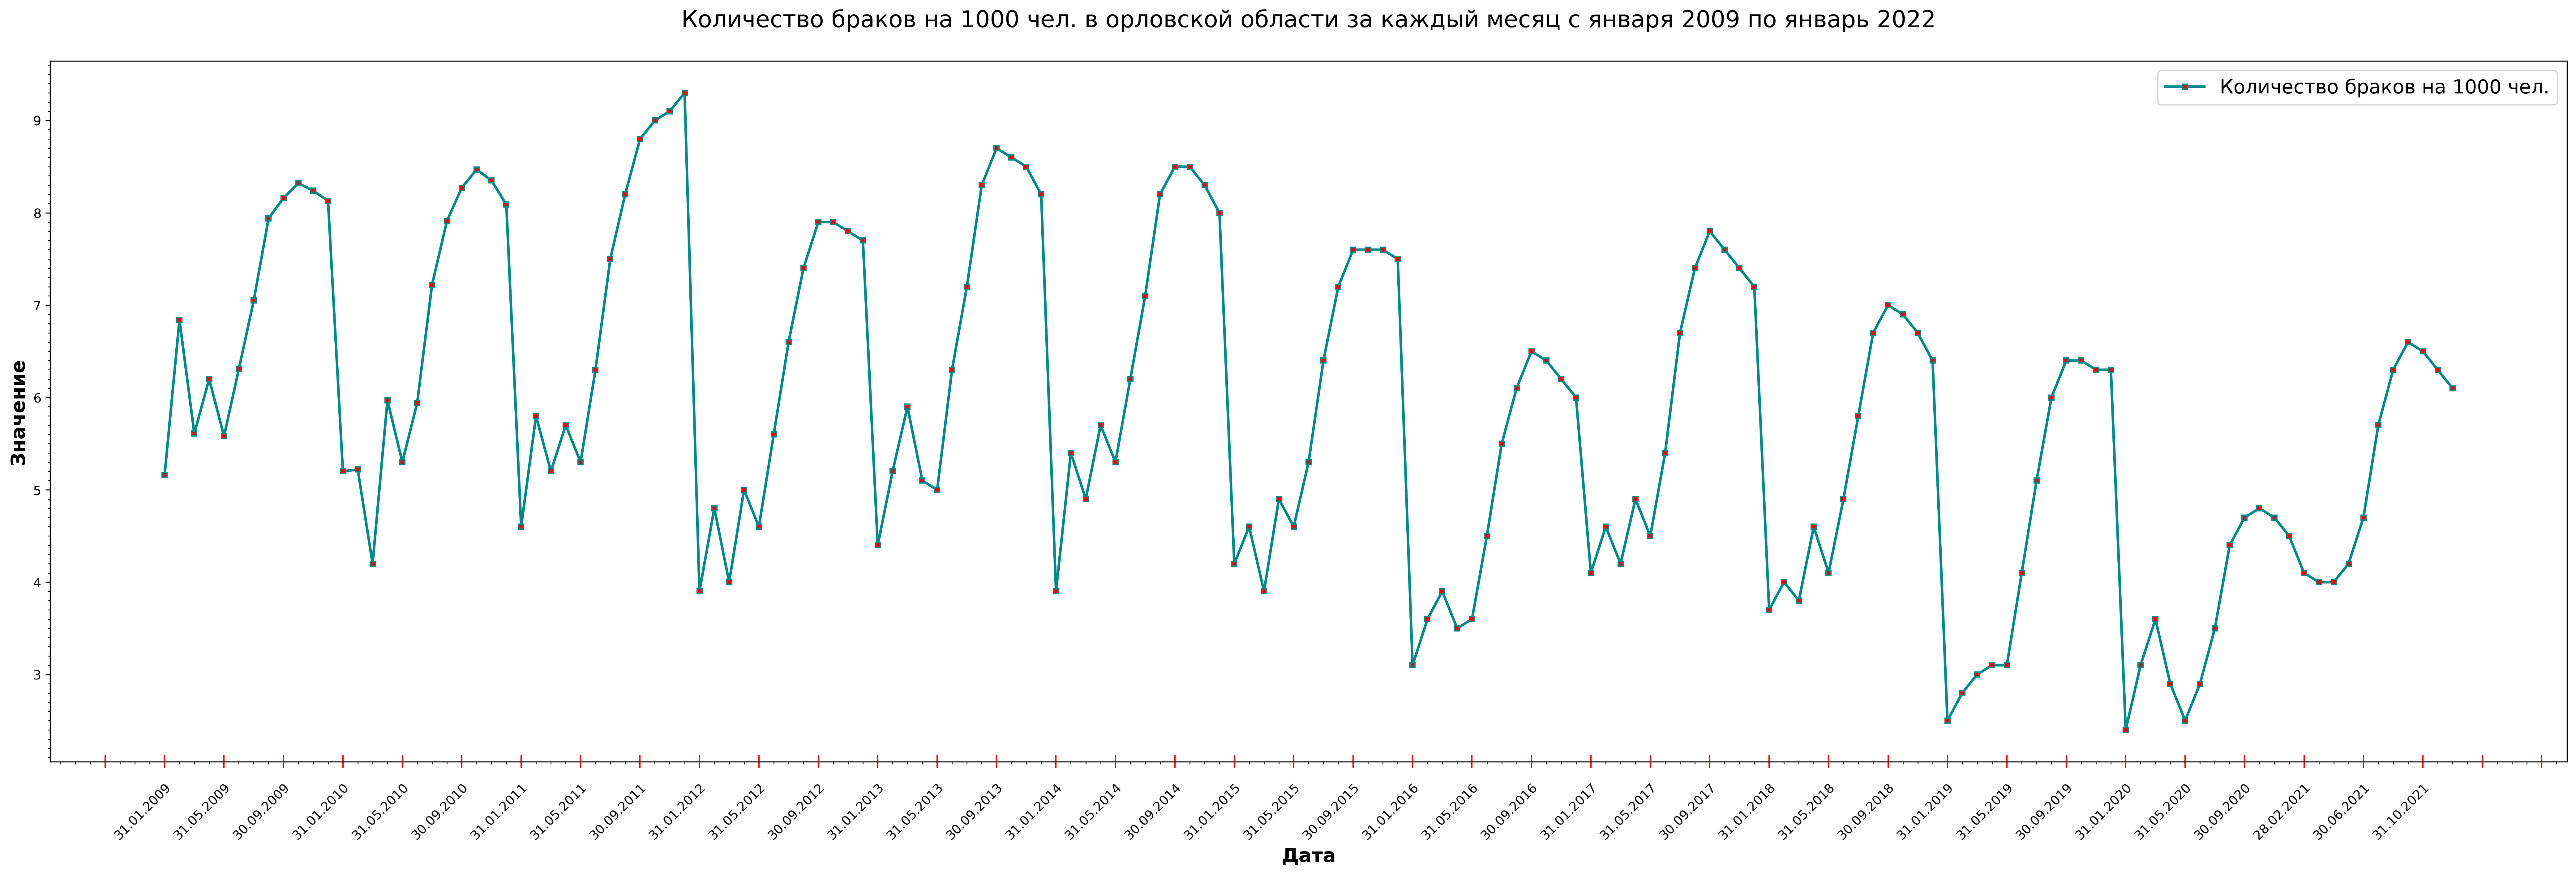

In [13]:
fig, ax = plt.subplots(dpi=300)

x = df_m_clean['дата']
y = df_m_clean['значение']

ax.plot(x, y, color='darkcyan', lw=2, ls='-', marker='s', markersize=4, markerfacecolor='red', label='Количество браков на 1000 чел.')

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.legend(loc=0, prop={'size': 15})
ax.set_xlabel('Дата', fontsize=15, fontweight='bold')
ax.set_ylabel('Значение', fontsize=15, fontweight='bold')
ax.set_title('Количество браков на 1000 чел. в орловской области за каждый месяц с января 2009 по январь 2022\n',
            fontsize=18)

ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'r',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'k',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               labelbottom = True)    #  Рисуем подписи снизу

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.set_figwidth(35)
fig.set_figheight(10)

plt.show()

### 1.3 Построение графика АКФ

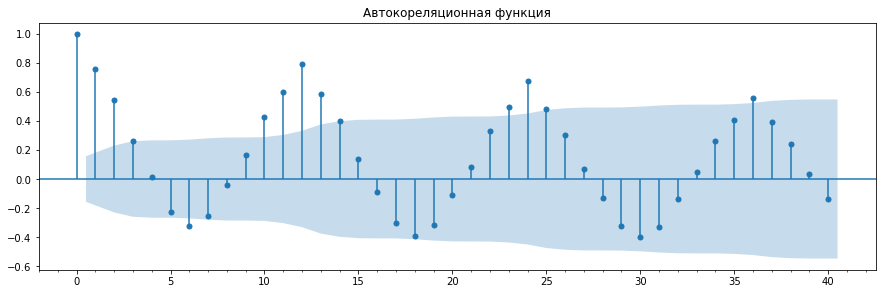

In [212]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(211)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig = sm.graphics.tsa.plot_acf(df_m_clean['значение'], lags=40, ax=ax, alpha=0.05, title='Автокореляционная функция')

##### Каждые 12 лагов достигается максимальное значение АКФ, что говорит о наличии сезонности; 

In [16]:
acf_array = sm.tsa.stattools.acf(df_m_clean['значение'], nlags=40, fft=False)

In [32]:
sm.tsa.stattools.acf(df_m_clean['значение'], nlags=40, alpha=0.05, fft=False)[1] # это доверительные интервалы для каждого лага

array([[ 1.        ,  1.        ],
       [ 0.59951381,  0.91437001],
       [ 0.31336848,  0.77460025],
       [-0.00182482,  0.51914185],
       [-0.25145009,  0.28209586],
       [-0.49109126,  0.04249832],
       [-0.59218709, -0.04933119],
       [-0.53298081,  0.02834948],
       [-0.3256675 ,  0.24679571],
       [-0.11803394,  0.45469852],
       [ 0.13759026,  0.71520655],
       [ 0.29772705,  0.90574756],
       [ 0.46218701,  1.12662638],
       [ 0.21132899,  0.96405973],
       [-0.00191079,  0.79500989],
       [-0.26702469,  0.54922323],
       [-0.49620993,  0.32245239],
       [-0.71558384,  0.10399197],
       [-0.80528138,  0.02552838],
       [-0.74115891,  0.10759456],
       [-0.54210455,  0.31829009],
       [-0.34699299,  0.51484336],
       [-0.09893241,  0.76371374],
       [ 0.05777687,  0.9330276 ],
       [ 0.22340144,  1.12602187],
       [ 0.00896816,  0.96027396],
       [-0.18495249,  0.79052056],
       [-0.42201784,  0.56272811],
       [-0.62265939,

In [30]:
acf_df = pd.DataFrame(acf_array, columns = ['АКФ'])

In [33]:
acf_df.head(13)

,АКФ
0,1.000000
1,0.756942
2,0.543984
3,0.258659
4,0.015323
5,-0.224296
6,-0.320759
7,-0.252316
8,-0.039436
9,0.168332


## 2) Визуальный анализ данных по рождаемости

##### Проделаем те жа шаги по подготовке данных и построению графика для данных по рождаемости

In [191]:
df_birth = pd.read_excel('birthrate.xlsx') # чтение данных из excel файла 

In [192]:
df_birth = df_birth.loc[df_birth['Субъект РФ'] == 'Орловская область'] # выбор нужного региона

In [193]:
df_birth.rename(columns={'Субъект РФ': ''}, inplace=True) # заранее переименовал колонку, которая будет датой 

In [194]:
df_birth = df_birth.set_index('').T # транспонирование таблицы

In [195]:
df_birth =  df_birth.reset_index()

In [196]:
df_birth.rename(columns={'index': 'дата', 'Орловская область': 'значение'}, inplace=True) # переименование колонки со значением по региону

In [197]:
df_birth # отображение

,дата,значение
0,2009-01-01,9.6
1,2009-02-01,10.1
2,2009-03-01,10.3
3,2009-04-01,10.4
4,2009-05-01,10.1
...,...,...
158,2022-03-01,6.8
159,2022-04-01,7.0
160,2022-05-01,7.0
161,2022-06-01,7.1


In [198]:
format1 = '%Y-%m-%d %H:%M:%S'

In [199]:
df_birth['дата']= df_birth.apply(lambda y: dt.datetime.strptime(str(y['дата']), format1), axis=1)

In [200]:
df_birth['дата'] = df_birth.apply(lambda x: dt.datetime.strftime(x['дата'], new_format), axis=1)

In [201]:
df_birth = df_birth.iloc[:155]

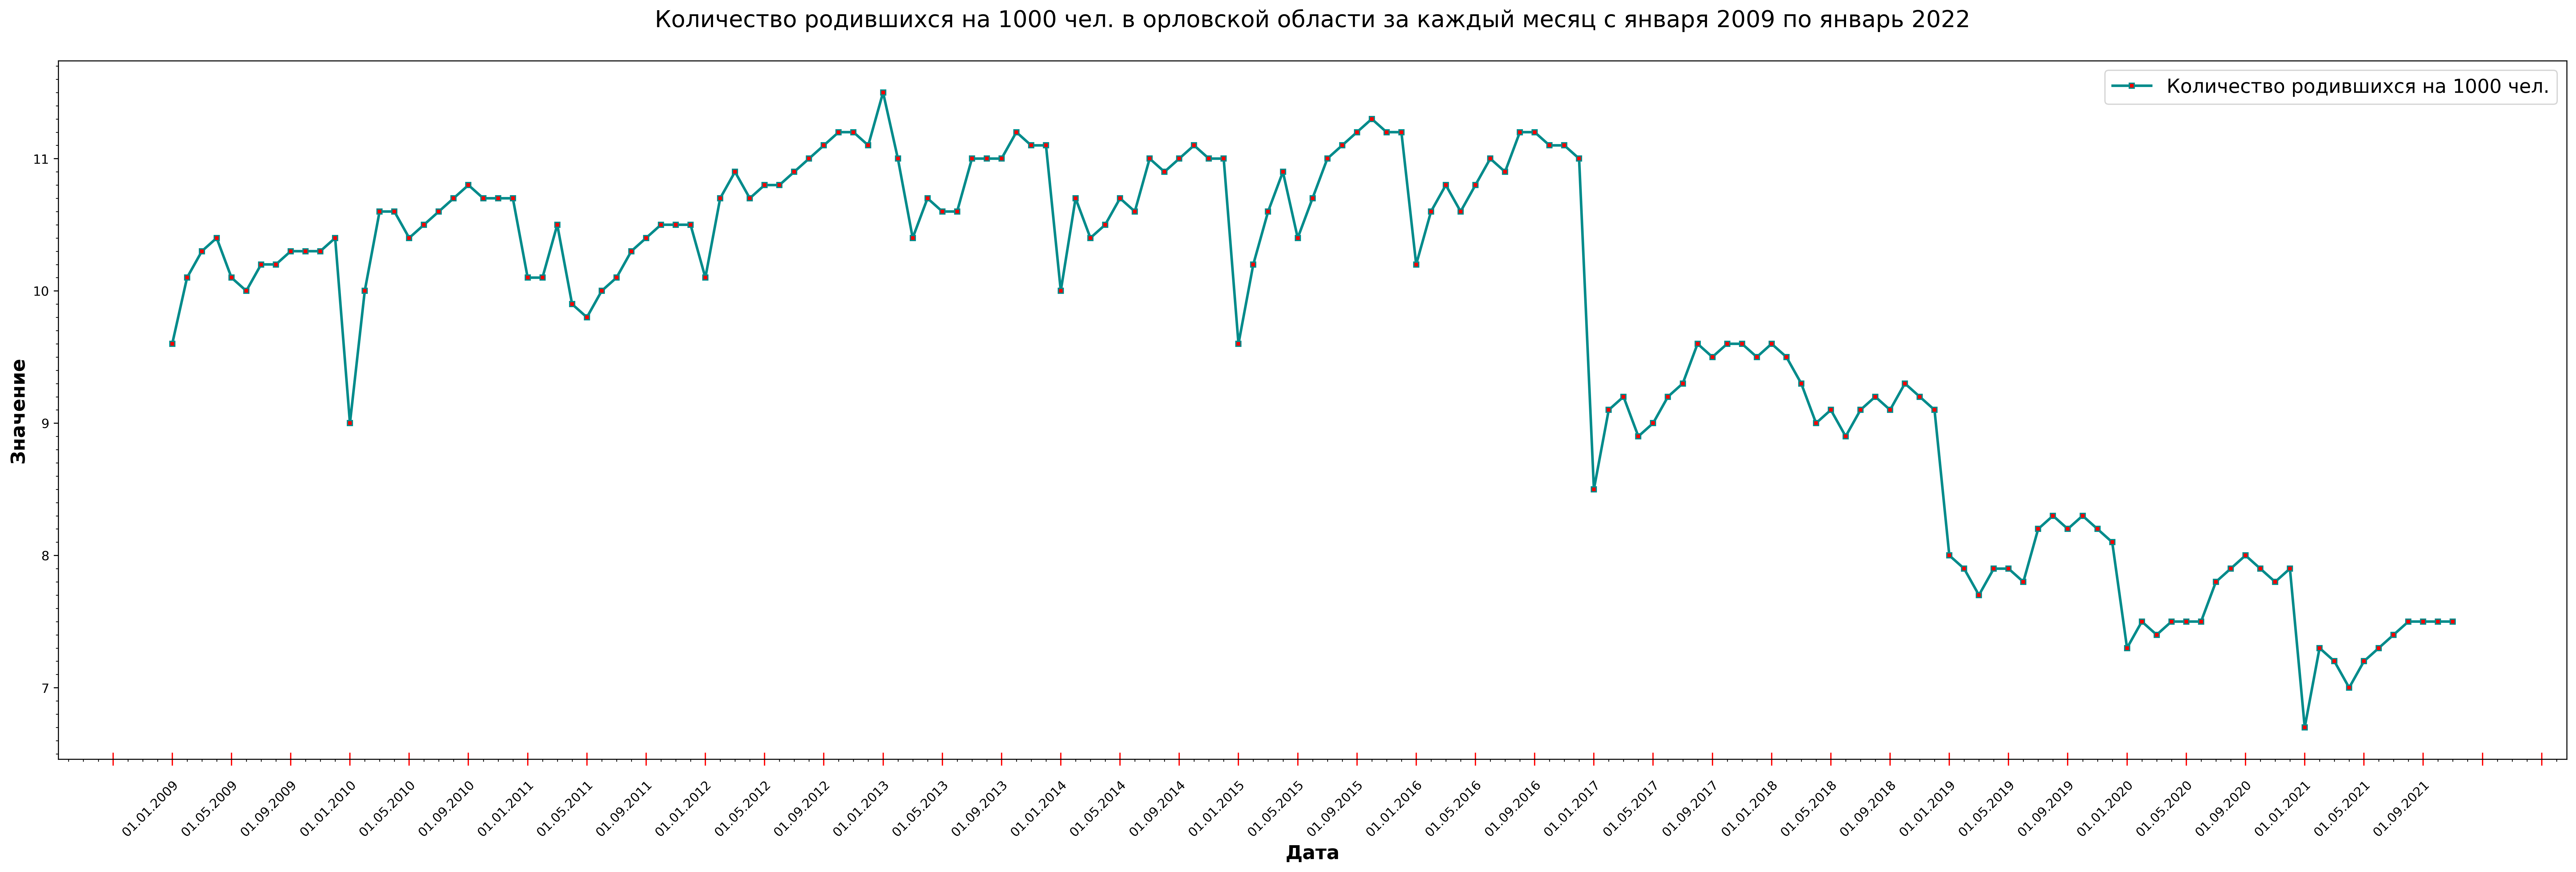

In [202]:
fig, ax = plt.subplots(dpi=300)

x = df_birth['дата']
y = df_birth['значение']

ax.plot(x, y, color='darkcyan', lw=2, ls='-', marker='s', markersize=4, markerfacecolor='red', label='Количество родившихся на 1000 чел.')

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.legend(loc=0, prop={'size': 15})
ax.set_xlabel('Дата', fontsize=15, fontweight='bold')
ax.set_ylabel('Значение', fontsize=15, fontweight='bold')
ax.set_title('Количество родившихся на 1000 чел. в орловской области за каждый месяц с января 2009 по январь 2022\n',
            fontsize=18)

ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'r',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'k',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               labelbottom = True)    #  Рисуем подписи снизу

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.set_figwidth(35)
fig.set_figheight(10)

plt.show()

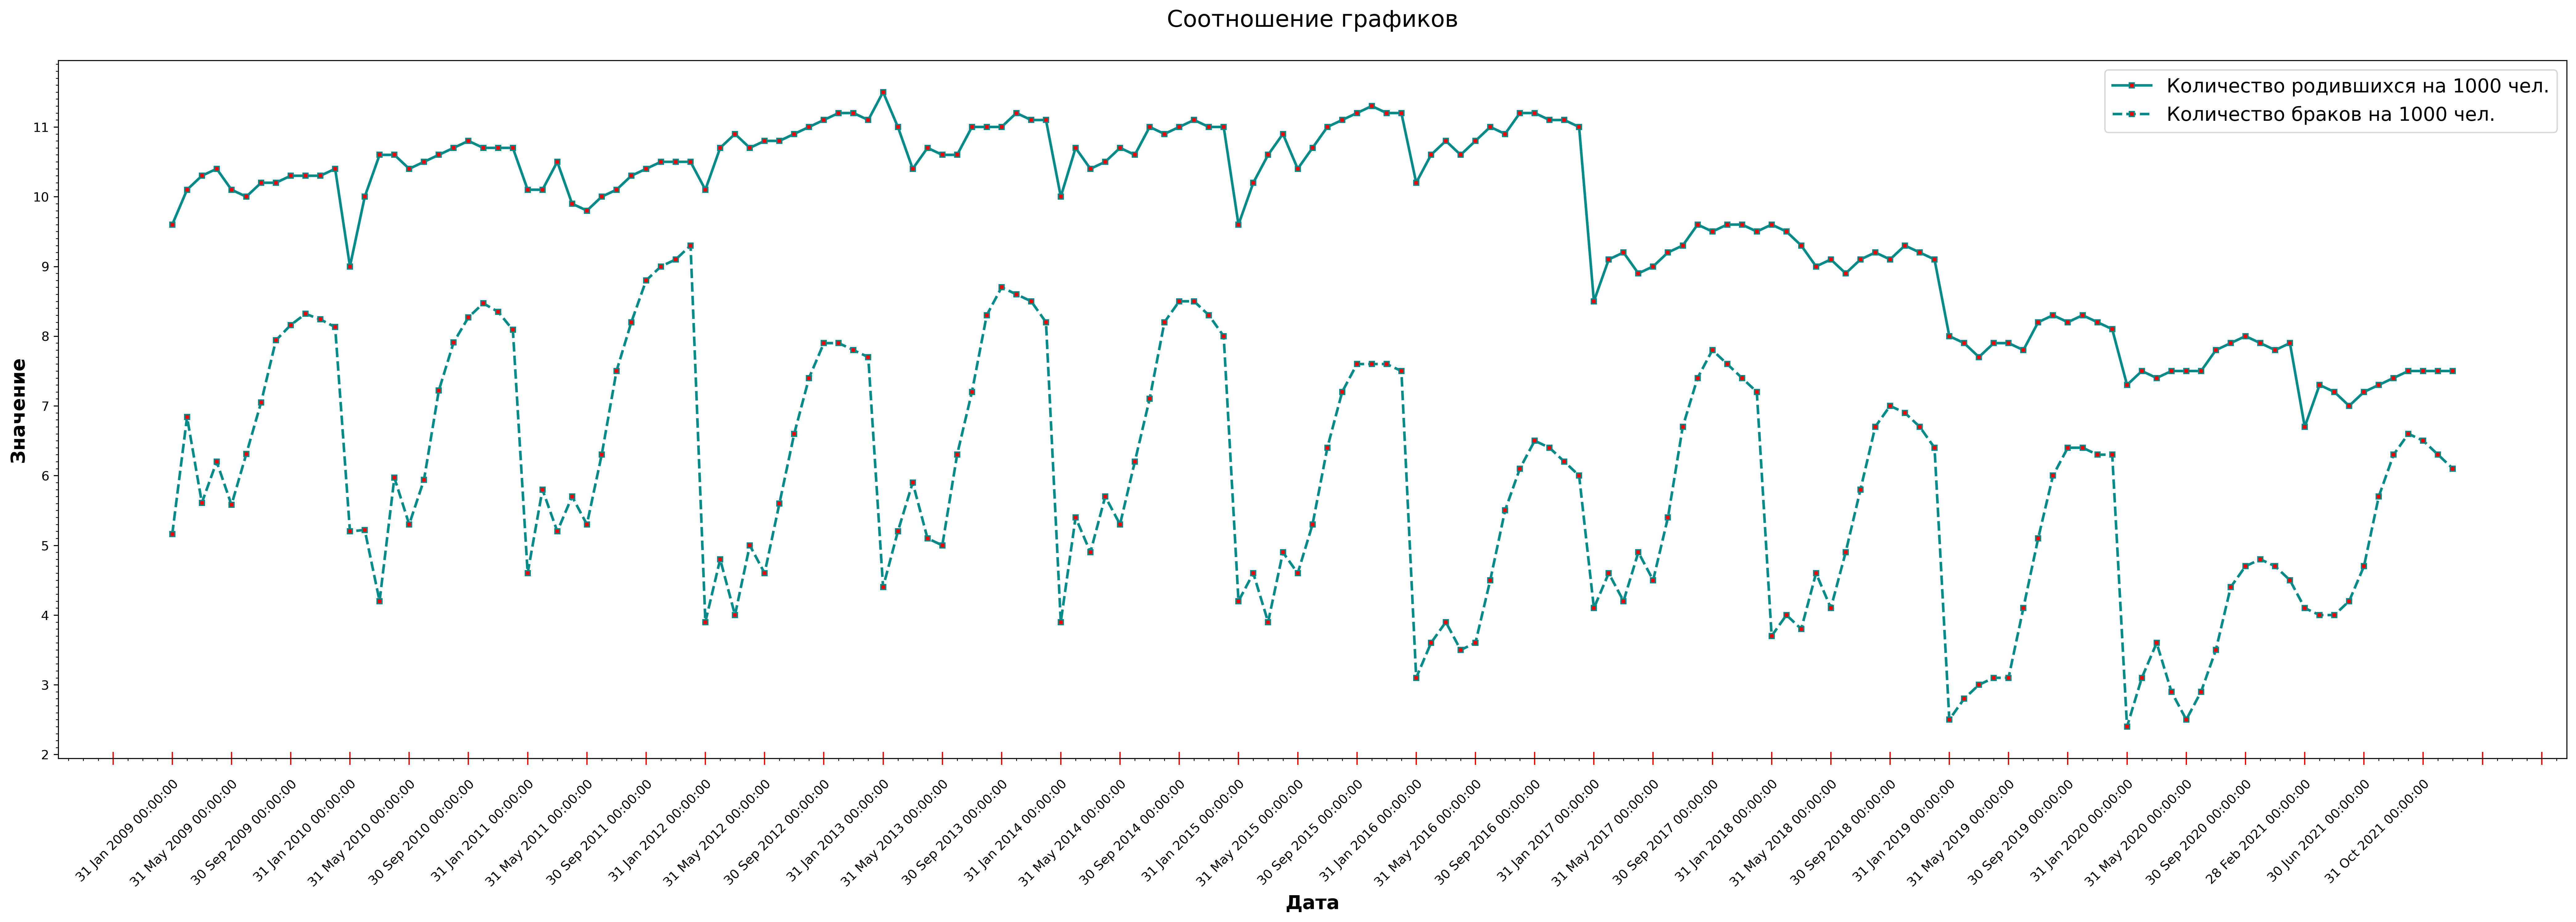

In [208]:
fig, ax = plt.subplots(dpi=300)

x = df_m_clean['дата']
y = df_birth['значение']

ax.plot(x, y, color='darkcyan', lw=2, ls='-', marker='s', markersize=4, markerfacecolor='red', label='Количество родившихся на 1000 чел.')

y = df_m_clean['значение']

ax.plot(x1, y, color='darkcyan', lw=2, ls='--', marker='s', markersize=4, markerfacecolor='red', label='Количество браков на 1000 чел.')

#  Исправление формата подписей оси x
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

ax.legend(loc=0, prop={'size': 15})
ax.set_xlabel('Дата', fontsize=15, fontweight='bold')
ax.set_ylabel('Значение', fontsize=15, fontweight='bold')
ax.set_title('Соотношение графиков\n',
            fontsize=18)

ax.tick_params(axis = 'x',    #  Применяем параметры к обеим осям
               which = 'major',    #  Применяем параметры к основным делениям
               direction = 'inout',    #  Рисуем деления внутри и снаружи графика
               length = 10,    #  Длинна делений
               width = 1,     #  Ширина делений
               color = 'r',    #  Цвет делений
               pad = 10,    #  Расстояние между черточкой и ее подписью
               labelsize = 10,    #  Размер подписи
               labelcolor = 'k',    #  Цвет подписи
               bottom = True,    #  Рисуем метки снизу
               labelbottom = True)    #  Рисуем подписи снизу

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.set_figwidth(35)
fig.set_figheight(10)

plt.show()

## 3) Расширенный тест Дики-Фуллера

###### H0: Есть единичный корень - ряд стационарен
###### H1: Единичного корня нет - ряд не стационарен

In [210]:
test = sm.tsa.stattools.adfuller(df_m_clean['значение'], regression='ct')
print(test)

(-3.8946914788686713, 0.01233824559323414, 14, 140, {'1%': -4.024934298469388, '5%': -3.4423275561224487, '10%': -3.1457269825072887}, 261.8853195175964)
